<a href="https://colab.research.google.com/github/Ashutosh-C605/C_codes-templates/blob/main/Explo-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()

Saving output_final.csv to output_final.csv


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("output_final.csv")  # or use: list(uploaded.keys())[0]
features = ['fs', 'L', 'C']
outputs = ['eff', 'vripple', 'iripple']

# Train/test split
train_df = df.iloc[:2000]
test_df = df.iloc[2000:]

X_train = train_df[features]
y_train = train_df[outputs]
X_test = test_df[features]
y_test = test_df[outputs]


In [10]:
from sklearn.preprocessing import StandardScaler

# Scale inputs
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Scale outputs
output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(3)
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6385 - mae: 0.5213 - val_loss: 0.6198 - val_mae: 0.4304 - learning_rate: 0.0050
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3563 - mae: 0.3527 - val_loss: 0.3824 - val_mae: 0.3404 - learning_rate: 0.0050
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3197 - mae: 0.3233 - val_loss: 0.3260 - val_mae: 0.3175 - learning_rate: 0.0050
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2548 - mae: 0.2698 - val_loss: 0.2657 - val_mae: 0.2655 - learning_rate: 0.0050
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2551 - mae: 0.2686 - val_loss: 0.3018 - val_mae: 0.2621 - learning_rate: 0.0050
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2103 - mae: 0.2383 - val_loss: 0.2623 - val_mae: 0.2772 - learning_rate: 0.0050
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2084 - mae: 0.2410 - val_loss: 0.2192 - val_mae: 0.2734 - learning_rate: 0.0050
Epoch 8/300
5

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error:", mse)
print("Test R² Score:", r2)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Mean Squared Error: 0.025224143639206886
Test R² Score: 0.9633504748344421


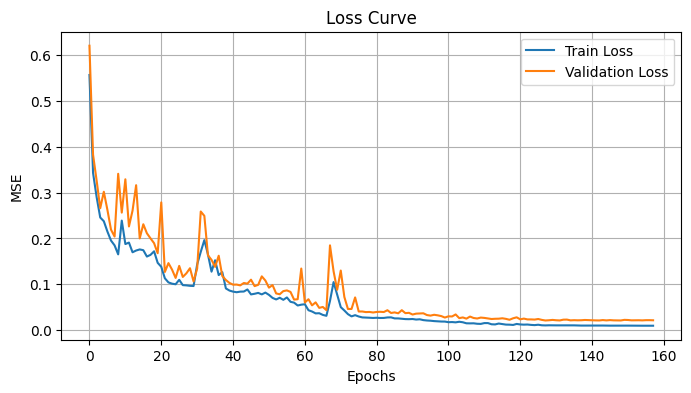

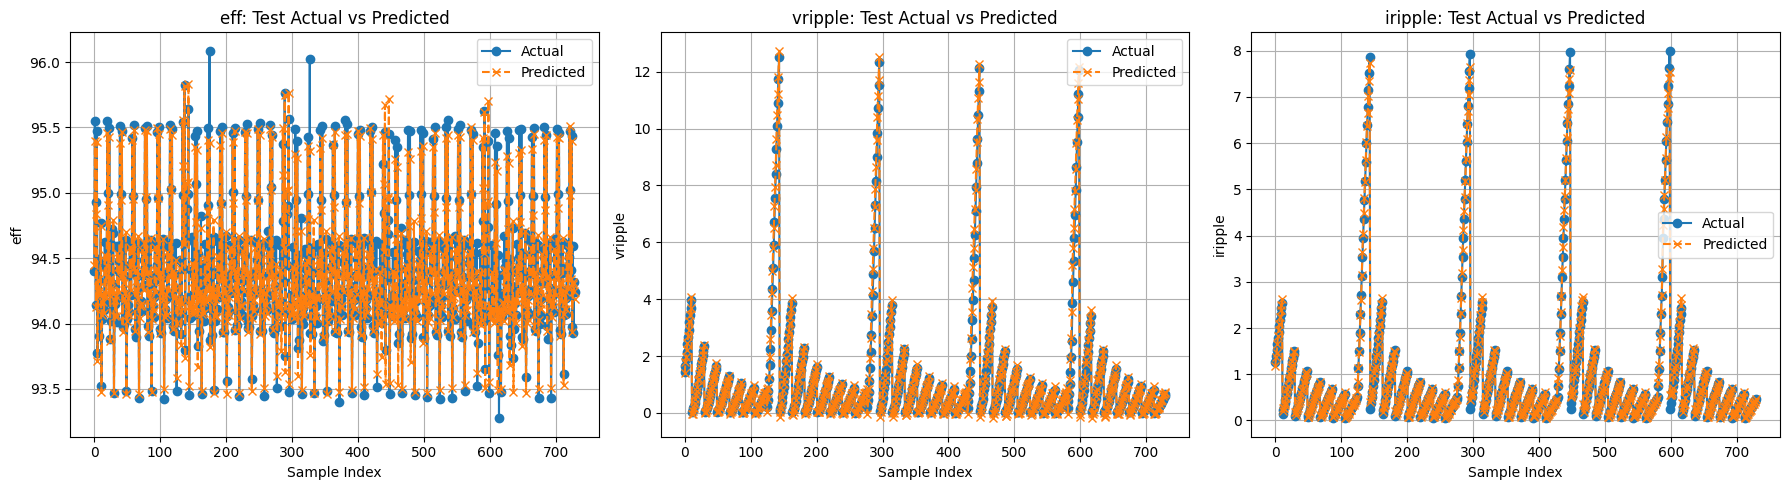

In [13]:
# Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

# Test Set - Actual vs Predicted
outputs = ['eff', 'vripple', 'iripple']
plt.figure(figsize=(18, 5))
for i, output in enumerate(outputs):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[output].values, label='Actual', linestyle='-', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', linestyle='--', marker='x')
    plt.title(f'{output}: Test Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(output)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


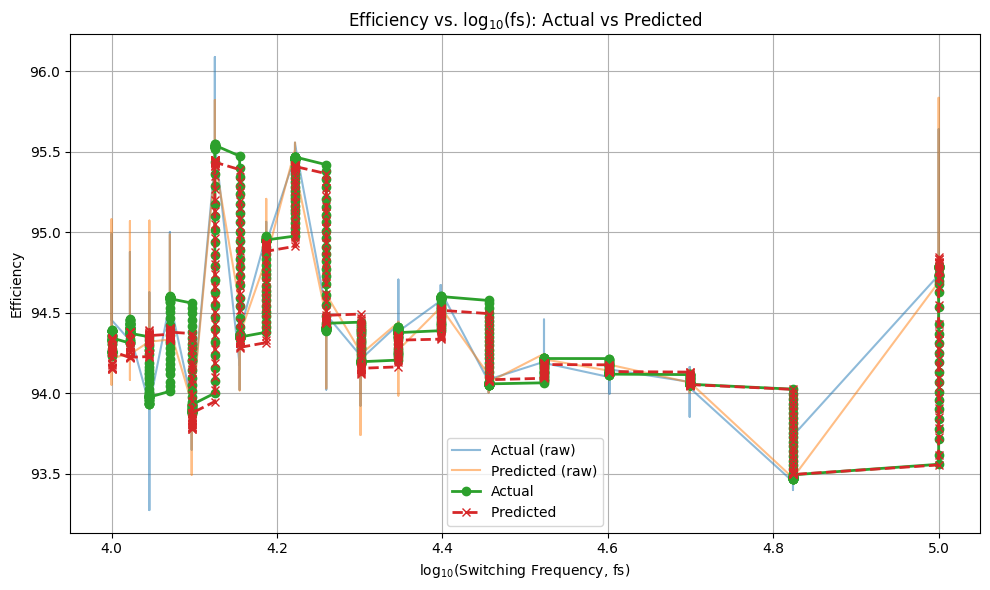

In [14]:
import matplotlib.pyplot as plt

# Index of 'eff' in outputs
eff_index = outputs.index('eff')

# Build results DataFrame
log_fs = np.log10(X_test['fs'].values)
results = pd.DataFrame({
    'log_fs':          log_fs,
    'eff_actual_raw':  y_test['eff'].values,
    'eff_pred_raw':    y_pred[:, eff_index]
})

# Sort by log_fs
results = results.sort_values('log_fs').reset_index(drop=True)

# Apply rolling mean to smooth (window size = 20 samples)
results['eff_actual_smooth'] = results['eff_actual_raw'].rolling(window=20, min_periods=1).mean()
results['eff_pred_smooth']   = results['eff_pred_raw'].rolling(window=20, min_periods=1).mean()

# Plot
plt.figure(figsize=(10, 6))

# raw curves (light)
plt.plot(results['log_fs'], results['eff_actual_raw'],  '-', alpha=0.5, label='Actual (raw)')
plt.plot(results['log_fs'], results['eff_pred_raw'],    '-', alpha=0.5, label='Predicted (raw)')

# smoothed curves (bold)
plt.plot(results['log_fs'], results['eff_actual_smooth'], 'o-', linewidth=2, label='Actual')
plt.plot(results['log_fs'], results['eff_pred_smooth'],   'x--', linewidth=2, label='Predicted ')

plt.xlabel(r"log$_{10}$(Switching Frequency, fs)")
plt.ylabel("Efficiency")
plt.title("Efficiency vs. log$_{10}$(fs): Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

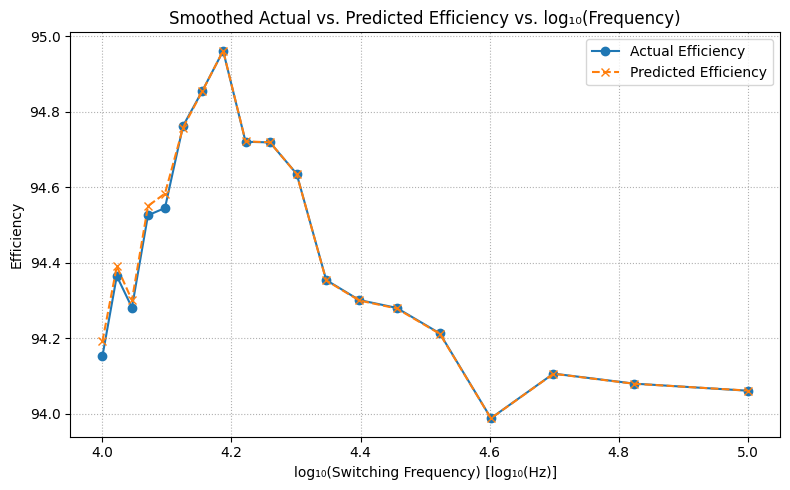

In [15]:

# 1) Build a DataFrame of frequency (raw and log), actual & predicted efficiency
df_plot = pd.DataFrame({
    'fs':        test_df['fs'],                   # raw switching frequency (Hz)
    'fs_log':    np.log10(test_df['fs']),         # log₁₀ of frequency
    'eff_true':  y_test['eff'].values,            # actual efficiency
    'eff_pred':  y_pred[:, 0]                     # predicted efficiency
})

# 2) For each unique log‑frequency, pick the one point with smallest absolute error
df_plot['err'] = np.abs(df_plot.eff_true - df_plot.eff_pred)
best_idxs = df_plot.groupby('fs_log')['err'].idxmin()
df_unique = df_plot.loc[best_idxs].sort_values('fs_log').reset_index(drop=True)

# 3) Smooth both curves with a centered rolling window of size 5
window = 5
df_unique['eff_true_sm'] = df_unique['eff_true'].rolling(window, center=True, min_periods=1).mean()
df_unique['eff_pred_sm'] = df_unique['eff_pred'].rolling(window, center=True, min_periods=1).mean()

# 4) Plot against log10(fs) directly
plt.figure(figsize=(8, 5))

plt.plot(df_unique['fs_log'], df_unique['eff_true_sm'],
         label='Actual Efficiency', marker='o', linestyle='-')
plt.plot(df_unique['fs_log'], df_unique['eff_pred_sm'],
         label='Predicted Efficiency', marker='x', linestyle='--')

plt.xlabel('log₁₀(Switching Frequency) [log₁₀(Hz)]')
plt.ylabel('Efficiency')
plt.title('Smoothed Actual vs. Predicted Efficiency vs. log₁₀(Frequency)')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


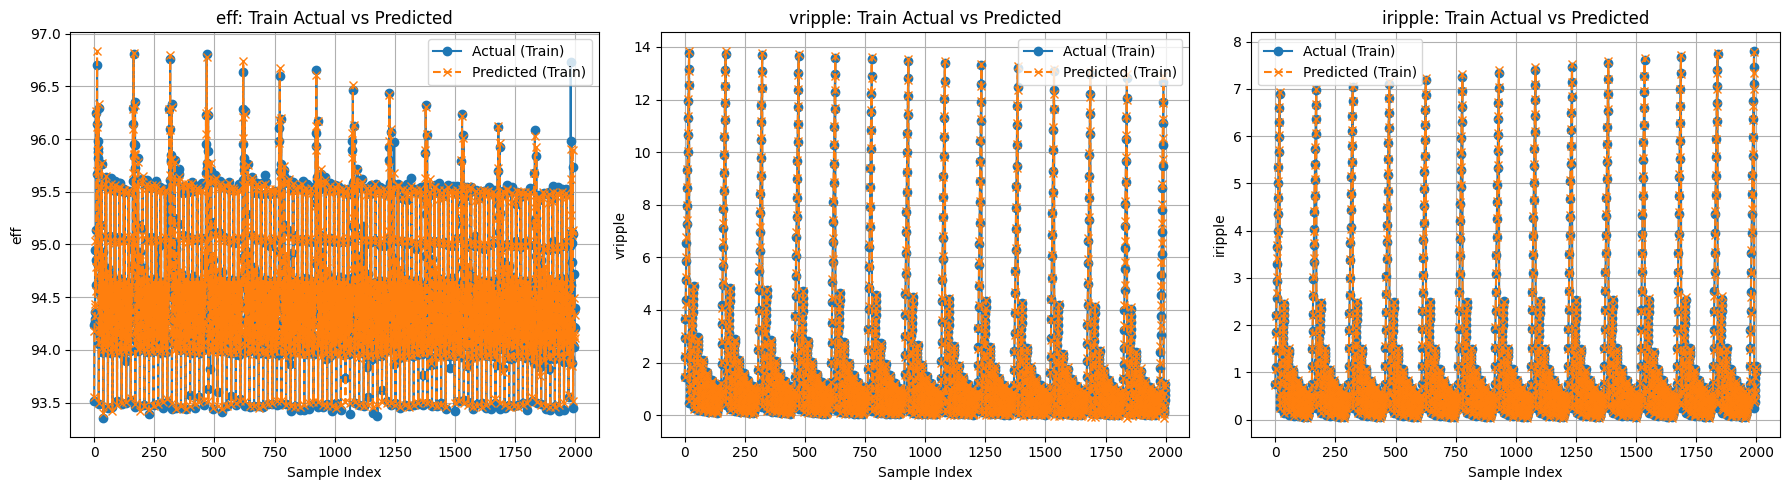

In [16]:
# Train Predictions
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = output_scaler.inverse_transform(y_train_pred_scaled)

plt.figure(figsize=(18, 5))
for i, output in enumerate(outputs):
    plt.subplot(1, 3, i+1)
    plt.plot(y_train[output].values, label='Actual (Train)', linestyle='-', marker='o')
    plt.plot(y_train_pred[:, i], label='Predicted (Train)', linestyle='--', marker='x')
    plt.title(f'{output}: Train Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(output)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
!pip install pyswarm

from pyswarm import pso

BOUNDS = {
    'fs': (1e4, 1e5),
    'L': (1e-6, 1.5e-3),
    'C': (5e-8, 5e-6)
}

MAX_VRIPPLE = 5.0
MAX_IRIPPLE = 1.0

def objective(x):
    fs, L, C = x
    X_input = pd.DataFrame([[fs, L, C]], columns=['fs', 'L', 'C'])
    X_scaled = input_scaler.transform(X_input)
    pred_scaled = model.predict(X_scaled)
    eff, vripple, iripple = output_scaler.inverse_transform(pred_scaled)[0]

    penalty = 0
    if vripple > MAX_VRIPPLE:
        penalty += (vripple - MAX_VRIPPLE) ** 2
    if iripple > MAX_IRIPPLE:
        penalty += (iripple - MAX_IRIPPLE) ** 2

    return -eff + penalty + 0.1 * (vripple + iripple)

lb = [BOUNDS['fs'][0], BOUNDS['L'][0], BOUNDS['C'][0]]
ub = [BOUNDS['fs'][1], BOUNDS['L'][1], BOUNDS['C'][1]]

best_input, best_score = pso(objective, lb, ub, swarmsize=20, maxiter=30, debug=True)


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=5e6ee8b6bf4f29ced69126b8c7a81051752f3d7b2520fcfe652f8abf98347360
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm
No constraints given.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━

In [19]:
X_input = np.array([best_input])
X_scaled = input_scaler.transform(X_input)
y_pred_scaled = model.predict(X_scaled)
eff, vripple, iripple = output_scaler.inverse_transform(y_pred_scaled)[0]

print("\n🎯 Best Input Found:")
print(f"fs = {best_input[0]:.2f}")
print(f"L  = {best_input[1]:.6e}")
print(f"C  = {best_input[2]:.6e}")

print("\n📈 Predicted Outputs:")
print(f"eff      = {eff:.4f}")
print(f"vripple  = {vripple:.4f}")
print(f"iripple  = {iripple:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

🎯 Best Input Found:
fs = 98246.98
L  = 7.496911e-06
C  = 2.039479e-06

📈 Predicted Outputs:
eff      = 94.6732
vripple  = 0.5906
iripple  = 0.1449


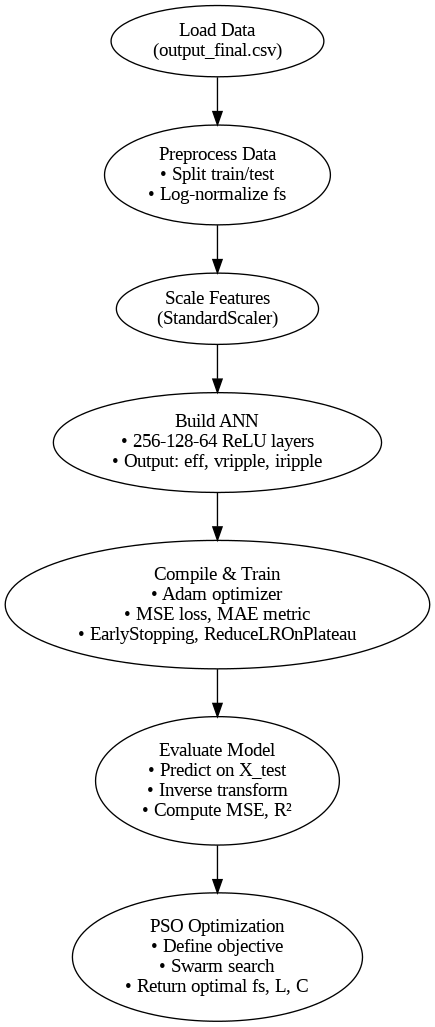

In [20]:
# Install graphviz library
!pip install graphviz

from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='ANN-PSO Model Workflow', format='png')

# Define nodes
dot.node('A', 'Load Data\n(output_final.csv)')
dot.node('B', 'Preprocess Data\n• Split train/test\n• Log-normalize fs')
dot.node('C', 'Scale Features\n(StandardScaler)')
dot.node('D', 'Build ANN\n• 256-128-64 ReLU layers\n• Output: eff, vripple, iripple')
dot.node('E', 'Compile & Train\n• Adam optimizer\n• MSE loss, MAE metric\n• EarlyStopping, ReduceLROnPlateau')
dot.node('F', 'Evaluate Model\n• Predict on X_test\n• Inverse transform\n• Compute MSE, R²')
dot.node('G', 'PSO Optimization\n• Define objective\n• Swarm search\n• Return optimal fs, L, C')

# Define edges
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')

# Render and save the diagram (in Colab this will display the image)
dot.render('ann_pso_flow_diagram', view=True)

# Display the diagram inline (for Jupyter/Colab)
from PIL import Image
from IPython.display import display

display(Image.open('ann_pso_flow_diagram.png'))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━

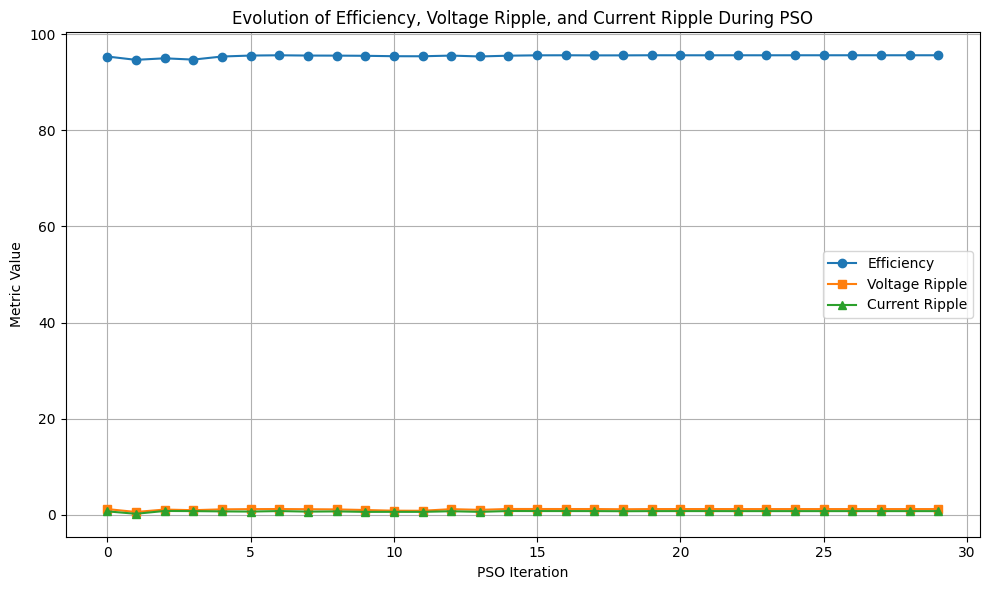

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso

# --- USER‑DEFINED VARIABLES (should already exist) ---
# features:        list of input names ['fs','L','C']
# input_scaler:    your fitted StandardScaler for inputs
# output_scaler:   your fitted StandardScaler for outputs
# model:           your trained Keras ANN
# lb, ub:          lists of lower/upper bounds for fs, L, C
# MAX_VRIPPLE, MAX_IRIPPLE: constraint scalars
# swarmsize, maxiter: your PSO settings

swarmsize = 20
maxiter   = 30

# --- HISTORY STORAGE ---
history = {'eff': [], 'vrip': [], 'irip': [], 'cost': [], 'iter': []}
eval_count = {'n': 0}

def instrumented_objective(x):
    """
    PSO objective + instrumentation: logs
    eff, vrip, irip, cost, and approximates iter index.
    """
    # 1) model prediction
    fs, L, C = x
    import pandas as pd
    X_df = pd.DataFrame([[fs, L, C]], columns=features)
    Xs = input_scaler.transform(X_df)
    pred_s = model.predict(Xs)
    eff, vrip, irip = output_scaler.inverse_transform(pred_s)[0]

    # 2) cost with penalties
    penalty = 0
    if vrip > MAX_VRIPPLE:
        penalty += (vrip - MAX_VRIPPLE)**2
    if irip > MAX_IRIPPLE:
        penalty += (irip - MAX_IRIPPLE)**2
    cost = -eff + 0.1*(vrip+irip) + penalty

    # 3) log into history
    it = eval_count['n'] // swarmsize
    history['eff'].append(eff)
    history['vrip'].append(vrip)
    history['irip'].append(irip)
    history['cost'].append(cost)
    history['iter'].append(it)
    eval_count['n'] += 1

    return cost

# --- RUN PSO ---
best_input, best_score = pso(instrumented_objective,
                             lb, ub,
                             swarmsize=swarmsize,
                             maxiter=maxiter,
                             debug=False)

# --- EXTRACT PER‑ITERATION BEST METRICS ---
iters = np.arange(maxiter)
eff_it, vrip_it, irip_it = [], [], []

for i in iters:
    # find all evals in iteration i
    idxs = [j for j,it in enumerate(history['iter']) if it == i]
    # pick the eval with lowest cost
    best_j = idxs[int(np.argmin([history['cost'][j] for j in idxs]))]
    eff_it.append(history['eff'][best_j])
    vrip_it.append(history['vrip'][best_j])
    irip_it.append(history['irip'][best_j])

# --- PLOT THE METRIC TRAJECTORIES ---
plt.figure(figsize=(10,6))
plt.plot(iters, eff_it,  marker='o', label='Efficiency')
plt.plot(iters, vrip_it,  marker='s', label='Voltage Ripple')
plt.plot(iters, irip_it,  marker='^', label='Current Ripple')
plt.xlabel('PSO Iteration')
plt.ylabel('Metric Value')
plt.title('Evolution of Efficiency, Voltage Ripple, and Current Ripple During PSO')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


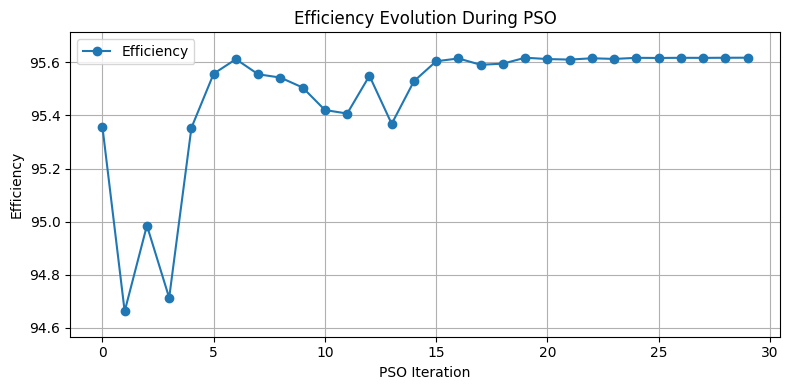

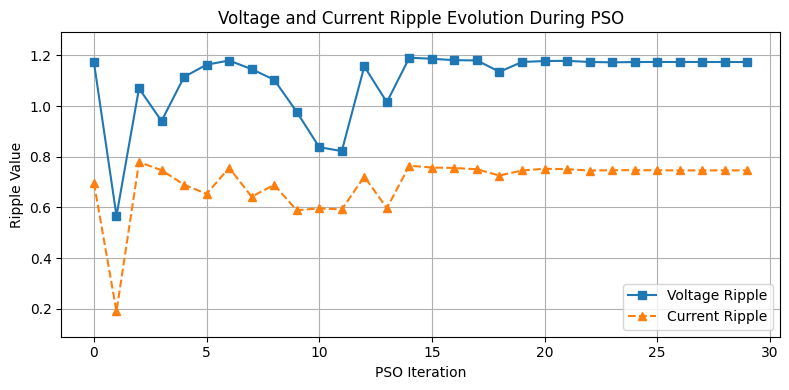

In [22]:
import matplotlib.pyplot as plt

# Ensure you have `iters`, `eff_it`, `vrip_it`, and `irip_it` from the PSO run

# 1) Efficiency Plot (Zoomed Y-Axis)
plt.figure(figsize=(8, 4))
plt.plot(iters, eff_it, marker='o', linestyle='-', label='Efficiency')
plt.xlabel('PSO Iteration')
plt.ylabel('Efficiency')
plt.title('Efficiency Evolution During PSO')
# Zoom y-axis to highlight small variation
eff_min, eff_max = min(eff_it), max(eff_it)
margin = 0.1 * (eff_max - eff_min)
plt.ylim(eff_min - margin, eff_max + margin)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Ripple Plot (Voltage & Current, Zoomed Y-Axis)
plt.figure(figsize=(8, 4))
plt.plot(iters, vrip_it, marker='s', linestyle='-', label='Voltage Ripple')
plt.plot(iters, irip_it, marker='^', linestyle='--', label='Current Ripple')
plt.xlabel('PSO Iteration')
plt.ylabel('Ripple Value')
plt.title('Voltage and Current Ripple Evolution During PSO')
# Zoom y-axis around the small ripple variations
all_ripples = vrip_it + irip_it
rip_min, rip_max = min(all_ripples), max(all_ripples)
margin_rip = 0.1 * (rip_max - rip_min)
plt.ylim(rip_min - margin_rip, rip_max + margin_rip)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
